# Import Packages

In [2]:
import matplotlib.pyplot as plt
import sys

sys.path.append("../PycastWorld")
sys.path.append("../Gym")
from gym_pycastworld.PycastWorldEnv import PycastWorldEnv

# Initialize environment

In [3]:
env = PycastWorldEnv()

# Grab the initial observation (not used here)
observation = env.reset()

# Random action selection. This should be done in some
# sort of "intelligent" manner.
action = env.action_space.sample()

# Advance the world one step. We could also have the step
# method advance more than step so that it takes fewer
# steps in total to get to the end goal.
observation, reward, done, info = env.step(action)

# Check if we reached the end goal
if done:
    print(f"  Found goal in {t+1} steps")

print(f"  Ended at position {env.world.getX()}, {env.world.getY()}")
env.close()

  Ended at position 3.45, 3.5000000026794895


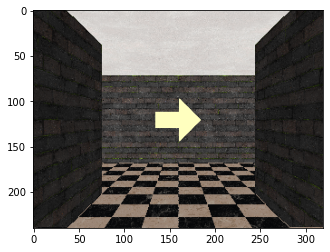

In [4]:
plt.imshow(observation)

## Set Position

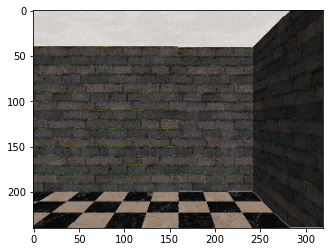

In [4]:
env.reset()
env.world.position(6.5, 3.5, 0)
observation = env.render(mode='rgb_array')
plt.imshow(observation)

## Moving

### Turn Left

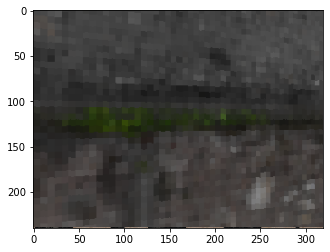

In [83]:
env.step(2)
observation, reward, done, info = env.step(action)
plt.imshow(observation)

### Move Forward

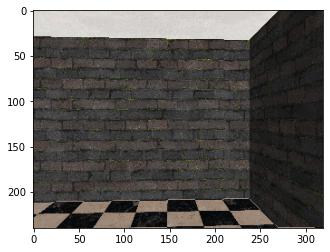

In [6]:
env.step(1)
observation, reward, done, info = env.step(action)
plt.imshow(observation)

### Turn Right

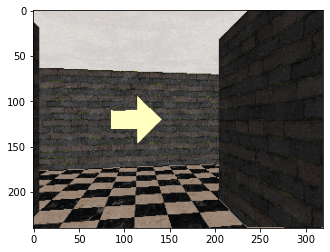

In [161]:
env.step(2)
observation, reward, done, info = env.step(action)
plt.imshow(observation)

## Reset Environment

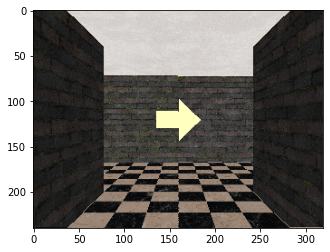

In [91]:
observation = env.reset()
plt.imshow(observation)

### Print Position

  Ended at position 3.5, 3.5


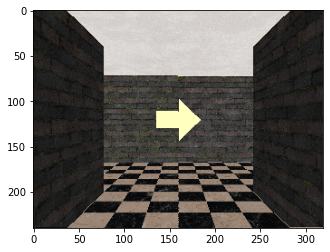

In [20]:
plt.imshow(observation)
print(f"  Ended at position {env.world.getX()}, {env.world.getY()}")

## List environment methods

In [25]:
dir(env.world)

['__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'atGoal',
 'direction',
 'getDirX',
 'getDirY',
 'getTurnSpeed',
 'getWalkSpeed',
 'getX',
 'getY',
 'position',
 'render',
 'reset',
 'savePNG',
 'turn',
 'update',
 'walk']

In [117]:
dir(env.world.walk)

['__call__',
 '__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__func__',
 '__ge__',
 '__get__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__self__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__']

In [146]:
?plt.imsave

In [154]:
def move_by(direction, episodes):
    """
    Save frames to forward, left, right directories
    direction (int): 0=left, 1=forward,2=right
    episodes (int): number of steps 
    """
    indx = 0
#     check if files exist    
    list_of_files = glob.glob('forward/*')
    if len(list_of_files) != 0:
        latest_file = max(list_of_files, key=os.path.getctime)
        print(latest_file)
#         If they do, keep incrementing file from latest written file name
        indx = int(latest_file[9:13]) + 1
#     Interate number of steps
    for i in range(episodes):
#         env.step(direction)
        observation, reward, done, info = env.step(direction)
        number = '{0:04}'.format(indx)
#         Save frame
        if direction == 1:
            plt.imsave("forward/f{}.png".format(number), observation)
        if direction == 2:
            plt.imsave("right/r{}.png".format(number), observation)
        if direction == 0:
            plt.imsave("left/l{}.png".format(number), observation)
        indx += 1

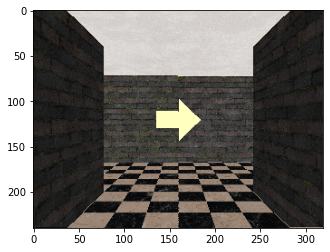

In [155]:
observation = env.reset()
plt.imshow(observation)

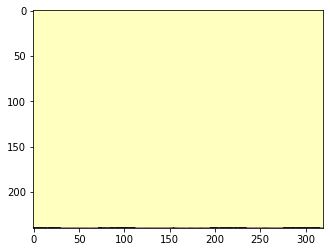

In [157]:
move_by(1, 100)
observation, reward, done, info = env.step(action)
plt.imshow(observation)

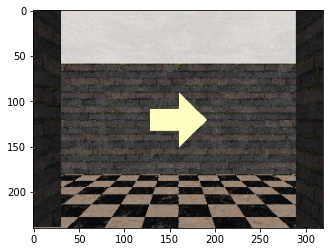

In [146]:
env.step(1)
env.step(1)
env.step(1)
env.step(1)
env.step(1)
env.step(1)
env.step(1)
env.step(1)
env.step(1)
env.step(1)
observation, reward, done, info = env.step(1)
plt.imshow(observation)

In [158]:
dir(env.world)

['__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'atGoal',
 'direction',
 'getDirX',
 'getDirY',
 'getTurnSpeed',
 'getWalkSpeed',
 'getX',
 'getY',
 'position',
 'render',
 'reset',
 'savePNG',
 'turn',
 'update',
 'walk']

In [162]:
dir(env.step)

['__call__',
 '__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__func__',
 '__ge__',
 '__get__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__self__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__']

In [165]:
dir(env.world)

['__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'atGoal',
 'direction',
 'getDirX',
 'getDirY',
 'getTurnSpeed',
 'getWalkSpeed',
 'getX',
 'getY',
 'position',
 'render',
 'reset',
 'savePNG',
 'turn',
 'update',
 'walk']